In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


Query Date: 2016-08-22


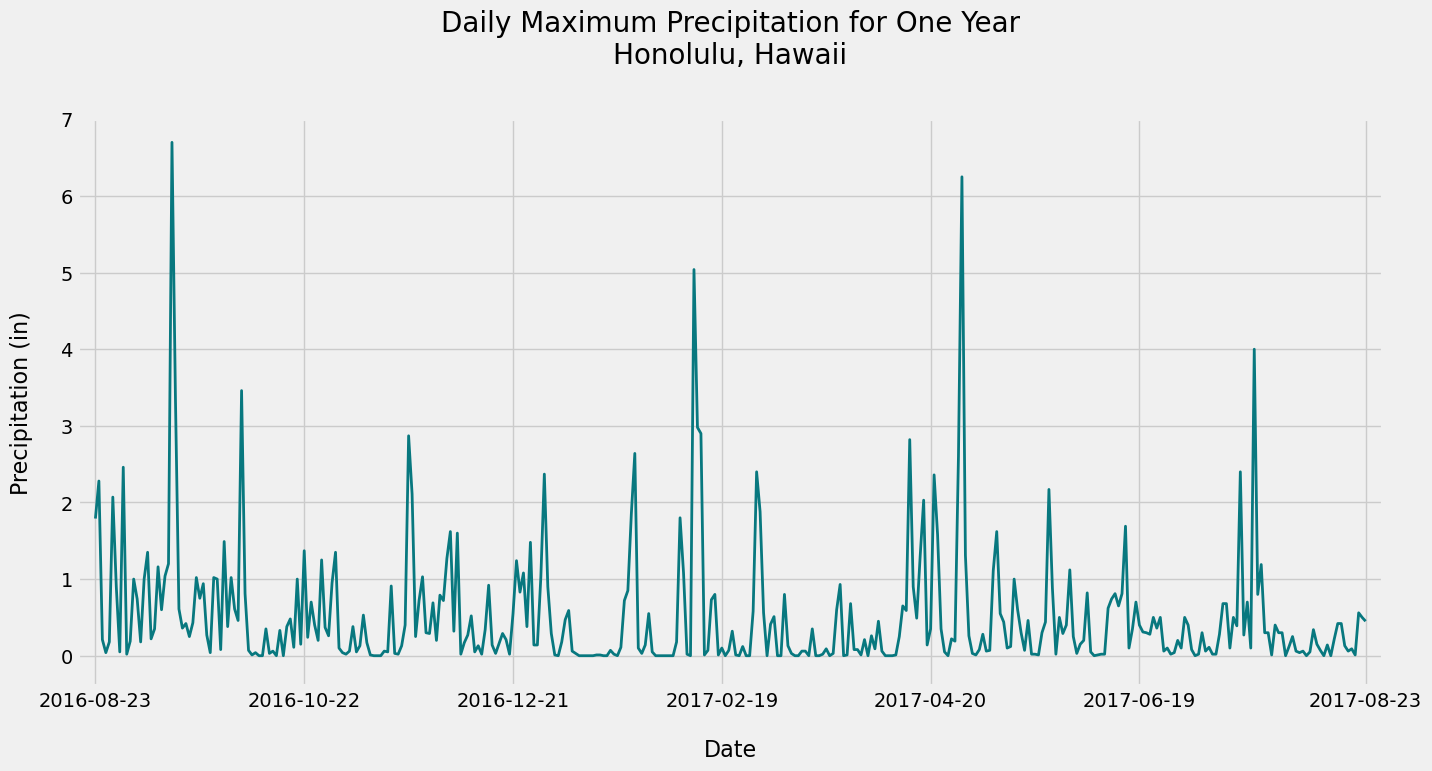

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = recent_date
# Calculate the date one year from the last date in data set.
# Calculate the date one year from the last date in data set.
year_ago_date=dt.date(2017, 8, 23) - dt.timedelta(days=366)
print('Query Date:', year_ago_date)
# Perform a query to retrieve the data and precipitation scores
year_prcp=(session.query(Measurement.date,func.max(Measurement.prcp))
                  .filter(func.strftime('%Y-%m-%d',Measurement.date) > year_ago_date)
                  .group_by(Measurement.date)
                  .all())
year_prcp
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df=pd.DataFrame(year_prcp, columns=['date', 'prcp'])
prcp_df.set_index('date',inplace=True)
prcp_df.head(10)

# Sort the dataframe by date
prcp_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.figsize']=(15,7)
prcp_df.plot(linewidth=2,alpha=1,rot=0, 
             xticks=(0,60,120,180,240,300,365),
             color='xkcd:deep aqua')

plt.xlim(-5,370)
plt.ylim(-0.4,7)
plt.yticks(size=14)
plt.xticks(fontsize=14)
plt.legend('',frameon=False)
plt.xlabel('Date',fontsize=16,color='black',labelpad=20)
plt.ylabel('Precipitation (in)',fontsize=16,color='black',labelpad=20)
plt.title('Daily Maximum Precipitation for One Year\nHonolulu, Hawaii',fontsize=20,pad=40)

plt.show()

In [38]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
locations = session.query(Measurement).group_by(Measurement.station).count()
print("{} stations.".format(locations))

9 stations.


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity=(session.query(Measurement.station,func.count(Measurement.station))
                         .group_by(Measurement.station)
                         .order_by(func.count(Measurement.station).desc())
                         .all())

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tobs=[Measurement.station, 
             func.min(Measurement.tobs), 
             func.max(Measurement.tobs), 
             func.avg(Measurement.tobs)]

most_active_st=(session.query(*tobs)
                       .filter(Measurement.station=='USC00519281')
                       .all())
most_active_st

most_active_st_temp=pd.DataFrame(most_active_st, columns=['station', 'min_temp', 
                                                          'max_temp', 'avg_temp'])
most_active_st_temp.set_index('station', inplace=True)
most_active_st_temp

,min_temp,max_temp,avg_temp
station,,,
USC00519281,54.0,85.0,71.663781


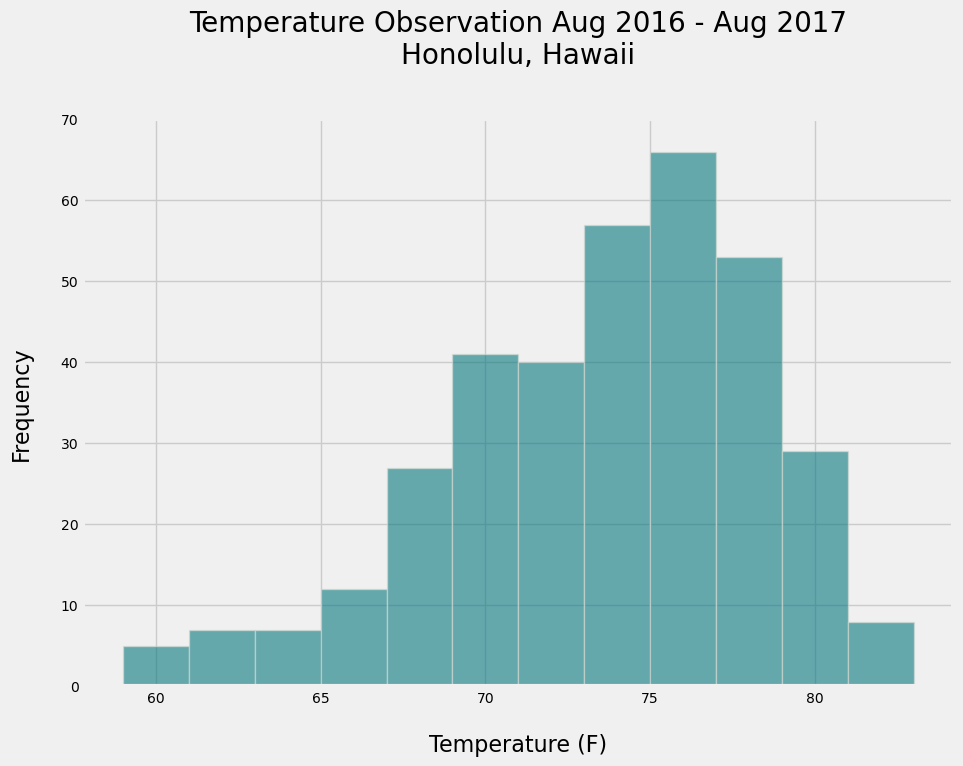

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_tobs=(session.query(Measurement.date,(Measurement.tobs))
                  .filter(func.strftime(Measurement.date) > year_ago_date)
                  .filter(Measurement.station=='USC00519281')
                  .all())
year_tobs


tobs_df=pd.DataFrame(year_tobs)
tobs_df.set_index('date',inplace=True)

plt.rcParams['figure.figsize']=(10,7)
plt.hist(tobs_df['tobs'],bins=12,alpha=0.6,edgecolor='xkcd:light gray',
         linewidth=1,color='xkcd:deep aqua')

plt.title('Temperature Observation Aug 2016 - Aug 2017\nHonolulu, Hawaii',fontsize=20,pad=40)
plt.xlabel('Temperature (F)',fontsize=16,color='black',labelpad=20)
plt.ylabel('Frequency',fontsize=16,color='black',labelpad=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0,70)

plt.show()

# Close Session

In [16]:
# Close Session
session.close()